In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from scipy import interpolate
init_printing(use_unicode = True) # Herramientas necesarias para hacer cálculos simbólicos.
%matplotlib inline

# 1)

## a)

In [2]:
# Función que devuelve la interpolación de lagrage para un número N de puntos de forma simbólica.
def lagrange(N):
    f = symarray('f',N) # Símbolos f_i a utilizar.
    t = symarray('t',N) # Simbolos t_i a utilizar.
    real_t = symbols('t') # Símbolo t que representa la vairable de la función.
    po = 0 # Inicialización del polinomio de Lagrange correspondiente. Más abajo se añaden los términos pertinentes.
    for i in range(N):
        mult = 1 # Término que multiplica a cada uno de los símbolos f_i en la expresión del polinomio.
        for j in range(N):
            if(i!=j):
                mult *=(real_t - t[j])/(t[i] - t[j]) # Se multiplica cada término por individual.
        po += f[i]*mult # En cada iteración se suma al polinomio el símbolo f_i multiplicado por el término 
                        # correspondiente.
    return po

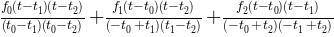

In [3]:
lagrange(3)

## b)

In [4]:
def adams(N):
    h = symbols('h') # Intervalo de tiempo a utilizar en la integración simbólica.
    t = symarray('t',N) # Simbolos t_i a utilizar.
    real_t = symbols('t') # Variable de la integración symbólica.
    po = lagrange(N) # Polinomio de lagrange, que se utiliza en la integración.
    for i in range(N):
        po = po.subs(t[i],t[0]-i*h) # Se sustituye cada t_i por lo indicado en el enunciado de la tarea. Se tuvo 
                                    # en cuenta la información acerca de sustitución simbólica de 
                                    # http://docs.sympy.org/dev/tutorial/basic_operations.html
    return simplify(integrate(po,(real_t,t[0],t[0]+h))) # Se integra y simplifica el polinomio correspondiente.

In [5]:
adams(3)

# 2)

## a)

In [179]:
G = 6.67384*10**(-11.) # Constante gravitacional en unidades del sistema internacional.
h = 30. # Lado en metros de la cuadrícula usada para la solución del problema.
density = 400. # Densidad volumétrica de masa en kg/m³.

xmin = -1500.
xmax = 1500.
ymin = -1500.
ymax = 1500.
zmin = -1500.
zmax = 1500. # Dimensiones en metros del espacio (cubo) en el que se va a hallar el potencial gravitacional
             # de un cubo de lado 270 m.
    
N = 101 # Este valor garantiza que la cuadrícula va a ser de 30 m de lado.

x = np.linspace(xmin,xmax,N)
y = np.linspace(ymin,ymax,N)
z = np.linspace(zmin,zmax,N) #  Coordenadas cartesianas de las cuadrículas.

xmesh, ymesh, zmesh = np.meshgrid(x, y, z) # Vectorización de las coordenadas. En este paso el espacio 
                                           # se ha discetizado en múltiples cuadrículas de lado 30 m.
    
cube = np.zeros((N,N,N)) # Array en el que se va a guardar el valor del campo en cada punto del espacio.

# Fijo la condición inicial partiendo del ansatz de la masa puntual en el origen del sistema coordenado.
# Se suma 3 en el radio para no tener el problema de dividir entre cero, ya que por la construcción previa
# de los diversos arreglos, el punto (0,0,0) está incluido. Además, al array total se le suma una constante
# que sirve para ajustar el valor del potencial de la carga puntual de tal forma que en los extremos sea cero.
# Dicha constante no afecta los resultados posteriores puesto que la importancia física del potencial recae en 
# su derivada.
placa = -(G*density*270.**3)/(np.sqrt(xmesh**2. + ymesh**2. + zmesh**2.)+3.) + (G*density*270.**3.)/1500.

# Condiciones de frontera de Dirichlet, teniendo en cuenta que el potencial es cero en las caras del cubo más
# grande.
placa[0] = 0.
placa[-1] = 0.
placa[:,0] = 0.
placa[:,-1] = 0.
placa[:,:,0] = 0.
placa[:,:,-1] = 0.

numiter = 1000 # Número de iteraciones para resolver la ecuación de Poisson para el potencial gravitacional.

# Implementación del método de relajación para solucionar la ecuación de Poisson, basado en la información del
# cuaderno 11-PDE.ipynb.
for __ in range(numiter):
    # Actualización del campo, partiendo de la discretización de las segundas derivadas. Se tomó como base la forma
    # de solucionar la ecuación de Laplace mostrada en 11-PDE.ipynb.
    placa = 1/6.*(np.roll(placa,1,axis=0) + np.roll(placa,-1,axis=0) 
                + np.roll(placa,1,axis=1) + np.roll(placa,-1,axis=1)
                + np.roll(placa,1,axis=2) + np.roll(placa,-1,axis=2)) # En estas líneas solo se tuvieron en cuenta
                                                                      # las segundas derivadas.
    
    placa[46:55,46:55,46:55] -= (1./6.)*4.*np.pi*G*density*h**2. # En esta línea se especifica que hay un cubo 
                                                                 # masivo centrado el el origen de coordenadas
                                                                 # con ayuda de slice notation.
    placa[0] = 0.
    placa[-1] = 0.
    placa[:,0] = 0.
    placa[:,-1] = 0.
    placa[:,:,0] = 0.
    placa[:,:,-1] = 0. # En cada iteración se imponen nuevamente las condiciones de frontera de Dirichlet.

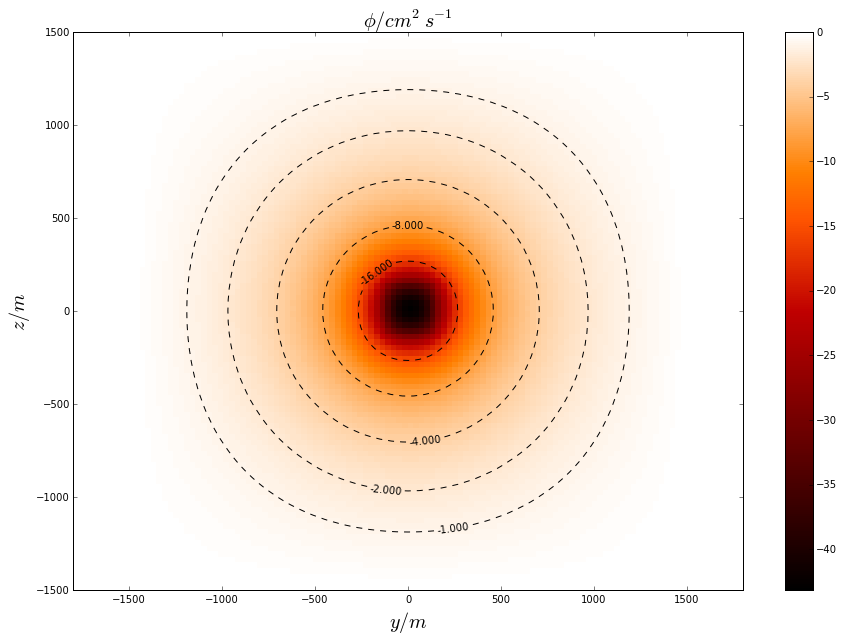

In [180]:
# Gráfica del potencial en el plano yz. Se superponen las líneas equipotenciales solicitadas.
plt.figure(figsize=(15,10))

plt.pcolor(y,z,placa[50]*100**2,cmap='gist_heat') # Se tiene en cuenta que se quiere graficar el potencial en
                                                  # unidades de cm²/s², de ahí que se multiplique por 100².
plt.axis('equal')

plt.colorbar() # Barra lateral que indica la intensidad del potencial de acuerdo al color mostrado en pantalla.

# Líneas equipotenciales. Se usó lo mencionado acerca del uso de clabel encontrado en 
# http://matplotlib.org/examples/pylab_examples/contour_demo.html.
cs = plt.contour(y,z,placa[50]*100**2,[-16.,-8.,-4.,-2.,-1.],linestyles = 'dashed',colors = 'k') 
plt.clabel(cs, inline=1, fontsize=10)

plt.xlabel(r'$y/m$',fontsize=20)
plt.ylabel(r'$z/m$',fontsize=20)
plt.title(r'$\phi/cm^2s^{-1}$',fontsize=20)

plt.show()

## b)

In [181]:
placa1 = np.zeros((N,N,N)) # Se define nuevamente el array placa para hallar ahora el campo del cubo de 270 m de 
                           # lado viéndolo como 9³ masas puntuales ubicadas dentro del cubo.

x_points = np.linspace(-120.,120.,9)
y_points = np.linspace(-120.,120.,9)
z_points = np.linspace(-120.,120.,9) # Posiciones de las masas puntuales.

for i in range(len(x_points)):
    for j in range(len(y_points)):
        for k in range(len(z_points)):
            # En cada iteración actualizo el arreglo placa sumando el potencial de cada masa puntual.
            # Se observó que había problemas para ajustar el valor del potencial en la vecindad de cero, esto se 
            # debe a que teóricamente el potencial en ese punto diverge. Se solucionó dicho problema sumando 3
            # en vez de 1 al radio y así evitar dividir por cero.
            placa1 += (-(G*density*270.**3.)/729.)/(np.sqrt((xmesh-x_points[i])**2. + (ymesh-y_points[j])**2. 
                                               + (zmesh-z_points[k])**2.)+3.)

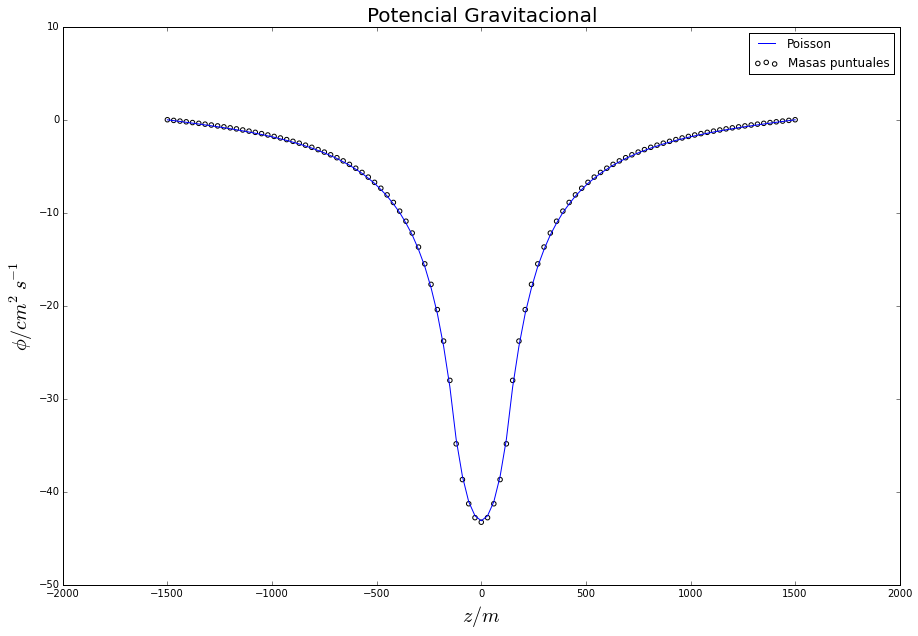

In [182]:
plt.figure(figsize=(15,10))
plt.plot(z,placa[50,50,:]*100**2, label = 'Poisson') # Gráfica del potencial en z obtenido al solucionar la 
                                                     # ecuación de Poisson, teniendo en cuenta las unidades
                                                     # deseadas.

# Gráfica del potencial en z obtenido con las masas puntuales.
plt.scatter(z,placa1[50,50,:]*100**2 + G*density*(100**2)*270.**3./1500.,facecolors='none',
            label = 'Masas puntuales') 
plt.xlabel(r'$z/m$',fontsize=20)
plt.ylabel(r'$\phi/cm^2s^{-1}$',fontsize=20)
plt.title(r'Potencial Gravitacional',fontsize=20)
plt.legend(loc = 'best')
plt.show()

## c)

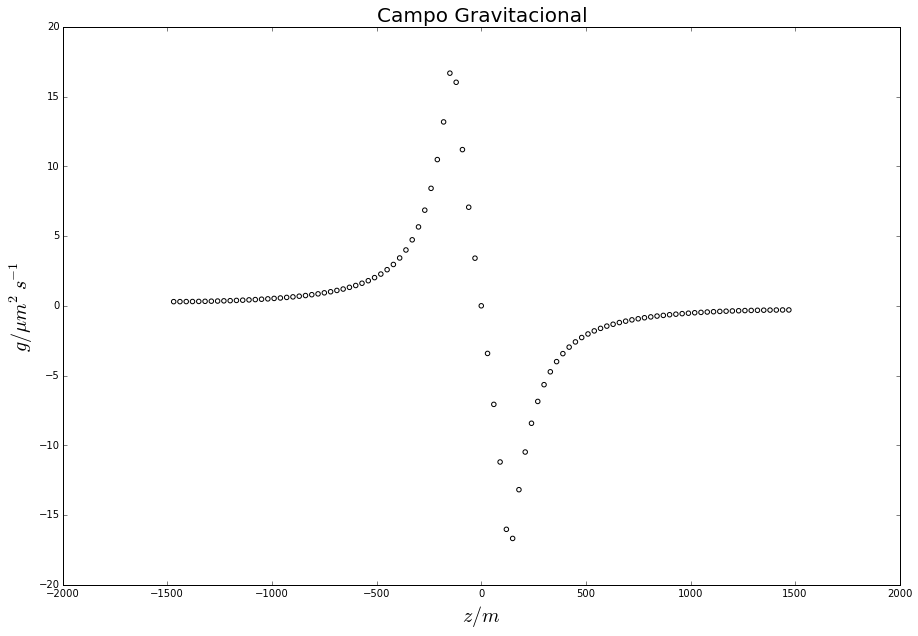

In [183]:
placa_forward = np.roll(placa[50,50,:],-1) 
placa_backward = np.roll(placa[50,50,:],1) # Datos necesarios para el cálculo de la derivada numérica.

dplaca = (placa_forward-placa_backward)/(2.*h) # Derivada numérica.

dplaca = dplaca[1:-1] # Se ignoran los datos de los extremos ya que no tienen sentido.

plt.figure(figsize=(15,10))

plt.scatter(z[1:-1],-dplaca*10**6,facecolors='none') # Gráfica del campo en z teniendo en cuenta que es -dV/dz, 
                                                     # y haciendo el cambio de unidades deseado.

plt.xlabel(r'$z/m$',fontsize=20)
plt.ylabel(r'$g/\mu m^2s^{-1}$',fontsize=20)
plt.title(r'Campo Gravitacional',fontsize=20)

plt.show()

## d)

In [184]:
field = interpolate.interp1d(z[1:-1],-dplaca,kind='cubic') # Se interpolan los datos de la derivada del potencial
                                                           # para obtener la función de campo en el eje z.

def f(Y):
    return np.array([Y[1], field(Y[0])]) # Función necesaria para solucionar la ecuación de movimiento. 
                                               # Se asume Y = [z,v_z]

# Método Runge Kutta dado por el profesor en el cuaderno 10-ODE.ipynb.
def one_Kutta4_step():
    global t
    global Deltat
    global Y
    K1 = f(Y)
    K2 = f(Y + Deltat*(1./2.*K1))
    K3 = f(Y + Deltat*(1./2.*K2))
    K4 = f(Y + Deltat*K3)
    Y+= Deltat * (1./6.*K1 + 1./3.*K2 + 1./3.*K3 + 1./6.*K4)
    t+= Deltat

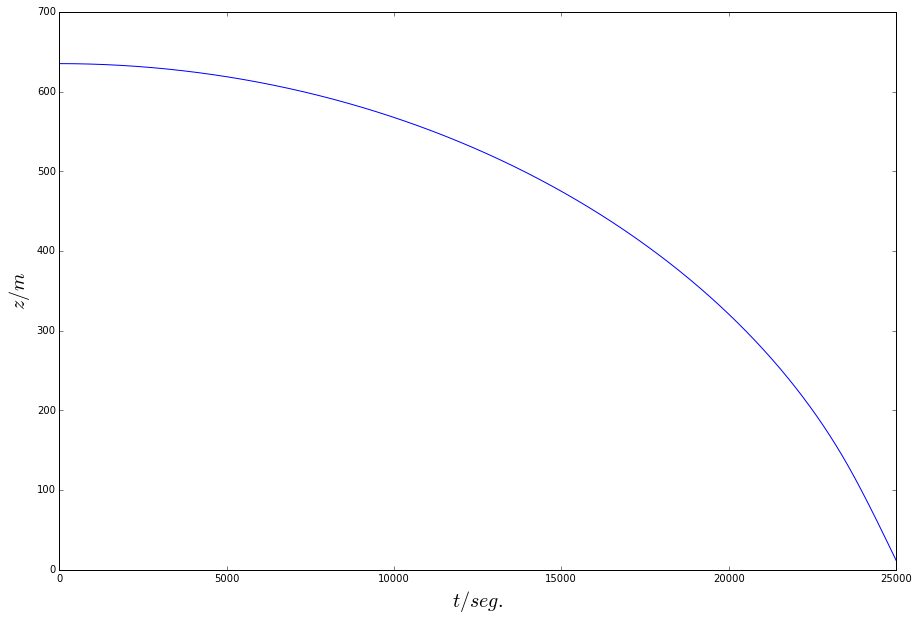

In [185]:
numIter = 25000 # Iteraciones para resolver la ecuación diferencial. Se observó que para este número de iteraciones
                # la masa ya había alcanzado la cara más cercana del cubo.

inital_position = 500. + 135.
Y = np.array([inital_position,0.]) # Condiciones iniciales de la ec. de movimiento. Se asume que la masa se 
                                   # pone 500 m por encima del cubo, el cual está centrado en el origen.

tmax = 50000. # Al correr el método para diversos tiempos se observó que la masa requería de un tiempo del orden
              # de 10⁵ para alcanzar la cara más cercana.
t = 0. 

Deltat = 1.

history = np.array([[t,Y[0],Y[1]]]) # Array en el que se guarda la información resultante de cada una de 
                                    # las interaciones.

# Implementación del Runge Kutta para solucionar la ecuación de movimiento.
for i in range(numIter):
    one_Kutta4_step()
    history = np.append(history,[[t, Y[0], Y[1]]],axis=0)

time = history[:,0]
z_mass = history[:,1]
v_mass = history[:,2]

# Gráfica de z vs t para la masa. Se verifica que para 50 seg. la masa ya ha alcanzado la superficie.
plt.figure(figsize=(15,10))
plt.plot(time,z_mass)
plt.xlabel(r'$t/seg.$',fontsize=20)
plt.ylabel(r'$z/m$',fontsize=20)
plt.show()

In [186]:
min_index = np.argmin(np.abs(z_mass-135.)) # Se halla el tiempo que tarda la masa en chocar contra el cubo,
                                           # hallando el índice donde su posición en z es aproximadamene 270 m.
print 'El tiempo que tarda la masa en chocar contra el cubo es: ', time[min_index]/3600.,' horas.' 

El tiempo que tarda la masa en chocar contra el cubo es:  6.52861111111  horas.
